In [102]:
cd "/content/drive/MyDrive/Colab Notebooks/codes"

/content/drive/MyDrive/Colab Notebooks/codes


In [39]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage

# load data

In [14]:
# Load your data
dataset = "data_DAC"
X_path = dataset + "/X.csv"
y_path = dataset + "/y.csv"
X = pd.read_csv(X_path)
y = pd.read_csv(y_path)

In [15]:
X.columns

Index(['Energy Burden (% income)', 'Avg. Annual Energy Cost ($)',
       'Total Households', 'Household Income',
       'Black/ African American (% pop.)',
       'American Indian/ Native Alaskan (% pop.)', 'Asian (% pop.)',
       'Native Hawaiian/ Other Pacific Islander (% pop.)',
       'White Hispanic or Latino (% pop.)',
       'White Non-Hispanic or Latino (% pop.)', 'Two or More Races (% pop.)',
       'Other Races (% pop.)', 'Less Than High School (% pop.)',
       'High School (% pop.)', 'Associates or Some College (% pop.)',
       'Bachelors or Higher (% pop.)'],
      dtype='object')

In [16]:
y

,Is Disadvantaged Community?
0,True
1,True
2,False
3,False
4,False
...,...
1693,False
1694,False
1695,False
1696,False


## Scale

In [17]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std.shape

from sklearn.preprocessing import Normalizer

# # Normalize the input features
# Nscaler = Normalizer()
# X_std = Nscaler.fit_transform(X_std)

## clustering

### Hierarchical Clustering with Agglomerative Clustering
Hierarchical Clustering is a family of clustering algorithms that create a hierarchy of clusters. Agglomerative Clustering is a type of hierarchical clustering that starts with each data point as a separate cluster and then recursively merges the closest pairs of clusters until a stopping criterion is met.

Agglomerative Clustering works by calculating the distance between each pair of data points and merging the two closest points into a single cluster. The algorithm then recalculates the distance between this new cluster and all the other clusters, and continues to merge the closest pairs of clusters until all the data points are in a single cluster or the desired number of clusters is reached.

One of the advantages of Agglomerative Clustering is that it can create clusters of varying sizes and shapes, and it can be used with a variety of distance metrics. It is also relatively easy to interpret the results of the clustering.

One of the disadvantages of Agglomerative Clustering is that it can be **computationally expensive for large datasets**, as it requires calculating the distance between each pair of data points. It can also be sensitive to the choice of distance metric and the stopping criterion used to determine the number of clusters.

#### Dendrogram

In [ ]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
                                    [model.children_, model.distances_, counts]
                                    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

AgglomerativeClustering(distance_threshold=10, n_clusters=None)


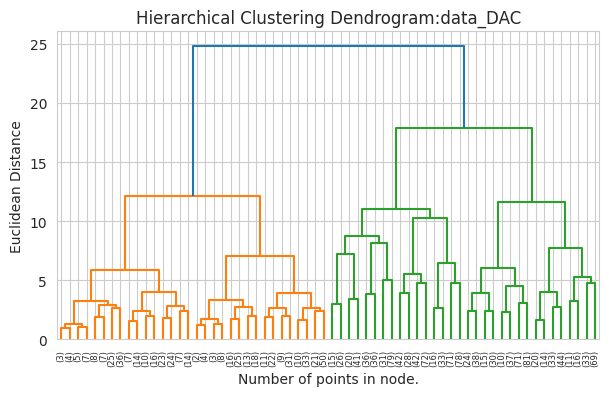

In [108]:
# we dont specify n_cluster to generate dendrogram
agg_model = AgglomerativeClustering(distance_threshold=10, n_clusters=None)

agg_model = agg_model.fit(X_std)
print(agg_model)
plt.figure(figsize=(7, 4))
plt.tight_layout()
plt.title(f"Hierarchical Clustering Dendrogram:{dataset}")
# plot the top levels of the dendrogram
plot_dendrogram(agg_model, truncate_mode="level", p=5, color_threshold = 20)
plt.axhline(y=200, color='red')
plt.xlabel("Number of points in node.")
plt.ylabel("Euclidean Distance")
plt.savefig(f"plot/dendrogram_{dataset}.png")
plt.show()

#### Silhouette analysis
what is Silhouette score
1: indicates that the data point is well-matched to its own cluster and poorly-matched to neighboring clusters.

0: indicates that the data point is on or very close to the decision boundary between two neighboring clusters.

-1: Means clusters are assigned in the wrong way.


Quantifying the quality of clustering via silhouette plots The silhouette score is calculated for each data point using the following formula:
silhouette score = (b - a) / max(a, b)

Where:

a is the average distance between a data point and all other points in the same cluster.
b is the average distance between a data point and all points in the nearest neighboring cluster.

In [109]:
from sklearn.metrics import silhouette_samples
from matplotlib import cm

def silhouette_analysis(model_labels = y, X = X_std, model = "Hierarchical", dataset = dataset ):

    cluster_labels = np.unique(model_labels)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X,
                       model_labels,
                       metric='euclidean')

    y_ax_lower, y_ax_upper = 0, 0
    yticks = []

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[model_labels == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper),
        c_silhouette_vals,
        height=1.0,
        edgecolor='none',
        color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)

    # add the average silhouette coefficient to the plot (dotted line)
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--")

    plt.yticks(yticks, cluster_labels)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.title(f"{dataset}_{model}_{len(cluster_labels)} clusters, average silhouette coefficient={round(silhouette_avg,2)}")
    plt.savefig(f"plot/silhouette_{dataset}_{model}_{len(cluster_labels)}_clusters.png")
    plt.show()

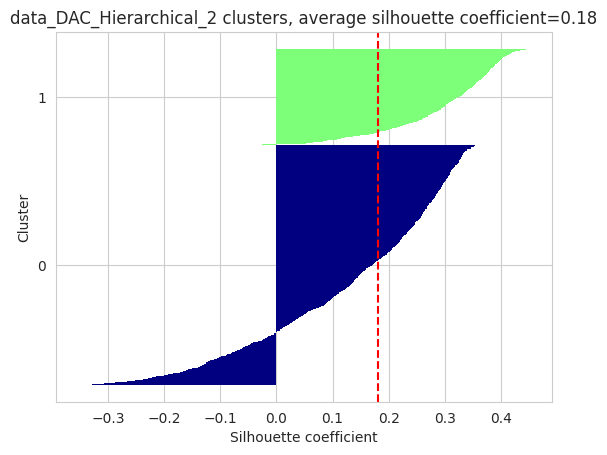

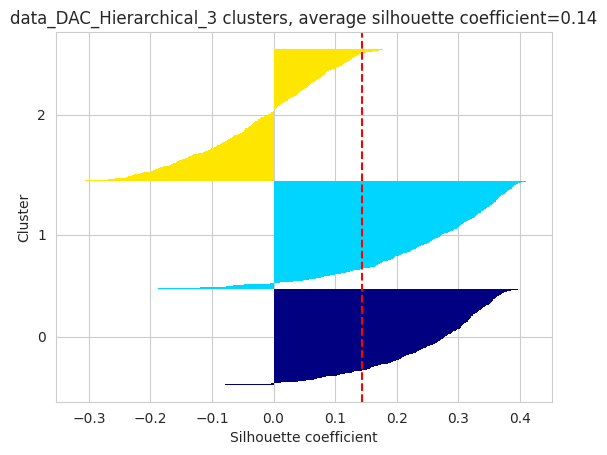

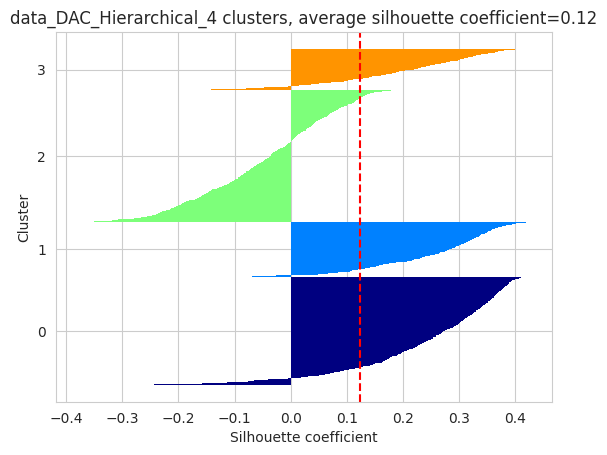

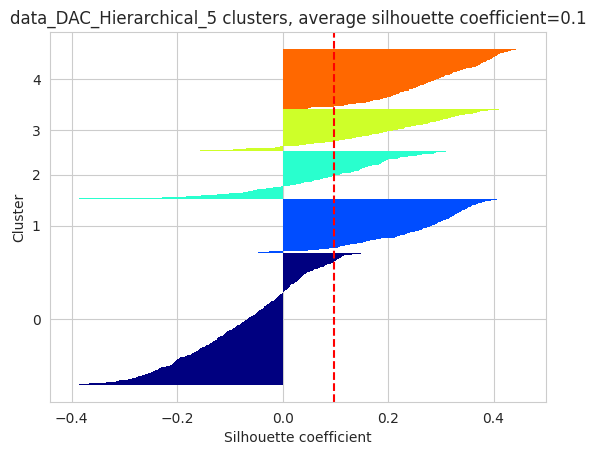

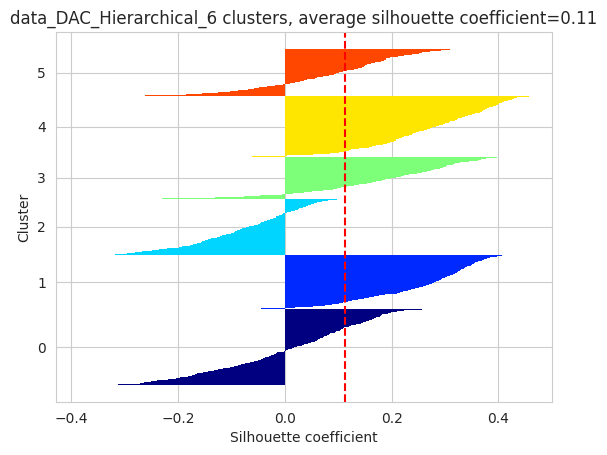

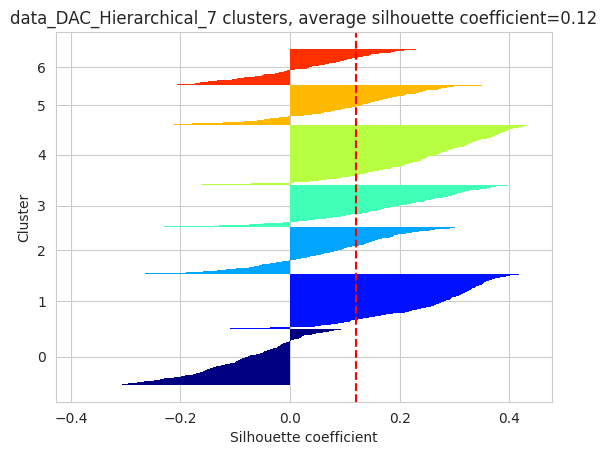

In [ ]:
for i in range(2,8):
    agglo = AgglomerativeClustering(n_clusters=i,
                                    metric='euclidean',
                                    linkage='ward')
    agglo = agglo.fit(X_std)
    silhouette_analysis(agglo.labels_,X_std, model = "Hierarchical")

### step 4

C:\Users\lzowe\anaconda3\envs\SMU_cluster_analysis\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Classification Report_data_DAC_Hierarchical_train:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85      1006
           1       0.00      0.00      0.00       352

    accuracy                           0.74      1358
   macro avg       0.37      0.50      0.43      1358
weighted avg       0.55      0.74      0.63      1358



C:\Users\lzowe\anaconda3\envs\SMU_cluster_analysis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lzowe\anaconda3\envs\SMU_cluster_analysis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lzowe\anaconda3\envs\SMU_cluster_analysis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

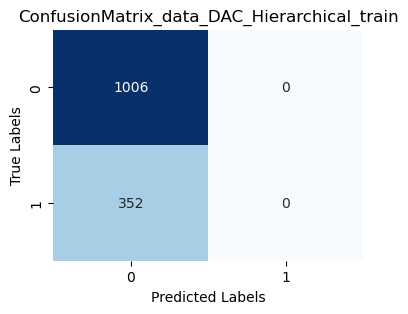

Classification Report_data_DAC_Hierarchical_test:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       255
           1       0.00      0.00      0.00        85

    accuracy                           0.75       340
   macro avg       0.38      0.50      0.43       340
weighted avg       0.56      0.75      0.64       340



C:\Users\lzowe\anaconda3\envs\SMU_cluster_analysis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lzowe\anaconda3\envs\SMU_cluster_analysis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lzowe\anaconda3\envs\SMU_cluster_analysis\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

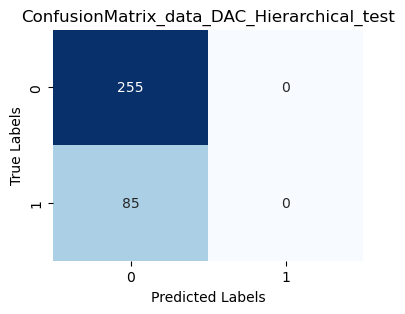

In [42]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve, validation_curve, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

model = "Hierarchical"
#DR = "PCA"
step = "step4"
features = X
target = y

# Convert 'True' and 'False' to 1 and 0
target = target.astype(int)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Set up MLP model
mlpclf = MLPClassifier(hidden_layer_sizes=(100,), activation='logistic', solver='sgd', max_iter=1000, random_state=42)
mlpclf.fit(X_train, y_train)


for flag in ["train", "test"]:
    
    actual_labels = y_train if flag == "train" else y_test
    pred_lables = mlpclf.predict(X_train) if flag == "train" else mlpclf.predict(X_test)


    print(f"Classification Report_{dataset}_{model}_{flag}:")
    print(classification_report(actual_labels, pred_lables))

    # Generate confusion matrix
    plt.figure(figsize=(4, 3))
    cm = confusion_matrix(actual_labels, pred_lables)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"ConfusionMatrix_{dataset}_{model}_{flag}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    #plt.savefig(f"plot_step4/CM{dataset}{DR}{flag}.png")
    plt.show()

### accuracy comparison

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve, validation_curve, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

model = "Hierarchical"

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)

# Set up MLP model
mlpclf = MLPClassifier(hidden_layer_sizes=(100,), activation='logistic', solver='sgd', max_iter=1000, random_state=42)
mlpclf.fit(X_train, y_train)


for flag in ["train", "test"]:
    
    actual_labels = y_train if flag == "train" else y_test
    pred_lables = mlpclf.predict(X_train) if flag == "train" else mlpclf.predict(X_test)


    print(f"Classification Report_{dataset}_{model}_{flag}:")
    print(classification_report(actual_labels, pred_lables))

    # # Generate confusion matrix
    # plt.figure(figsize=(4, 3))
    # cm = confusion_matrix(actual_labels, pred_lables)
    # sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    # plt.title(f"ConfusionMatrix_{dataset}_{DR}_{model}_{flag}")
    # plt.xlabel("Predicted Labels")
    # plt.ylabel("True Labels")
    # plt.savefig(f"plot_step4/CM{step}{dataset}{DR}{model}{flag}.png")
    # plt.show()

C:\Users\lzowe\anaconda3\envs\SMU_cluster_analysis\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Classification Report_data_DAC_Hierarchical_train:
              precision    recall  f1-score   support

       False       0.87      0.94      0.90      1006
        True       0.77      0.61      0.68       352

    accuracy                           0.85      1358
   macro avg       0.82      0.77      0.79      1358
weighted avg       0.85      0.85      0.85      1358

Classification Report_data_DAC_Hierarchical_test:
              precision    recall  f1-score   support

       False       0.87      0.93      0.90       255
        True       0.74      0.56      0.64        85

    accuracy                           0.84       340
   macro avg       0.80      0.75      0.77       340
weighted avg       0.83      0.84      0.83       340



C:\Users\lzowe\anaconda3\envs\SMU_cluster_analysis\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

       False       0.58      0.45      0.51      1261
        True       0.03      0.05      0.04       437

    accuracy                           0.35      1698
   macro avg       0.31      0.25      0.27      1698
weighted avg       0.44      0.35      0.39      1698



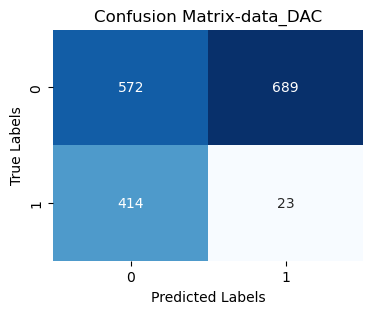

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
model = "Hierarchical"
# we decide choose two clusters
agglo_2_clusters = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
agglo_2_clusters = agglo_2_clusters.fit(X_std)

# compare actual vs predicted results
actual_labels = y
pred_lables = agglo_2_clusters.labels_


print("Classification Report:")
print(classification_report(actual_labels, pred_lables))

# Generate confusion matrix
plt.figure(figsize=(4, 3))
cm = confusion_matrix(actual_labels, pred_lables)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title(f"Confusion Matrix-{dataset}")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig(f"plot/confusionMatrix_{dataset}_{model}.png")
plt.show()

### Gaussian Mixture Model (GMM) Clustering
Gaussian Mixture Model (GMM) Clustering is a probabilistic clustering algorithm that assumes that the data points are generated from a mixture of Gaussian distributions. Each Gaussian distribution represents a cluster in the data, and the GMM algorithm estimates the parameters of the Gaussians to fit the data.

The GMM algorithm works by first initializing the parameters of the Gaussians, including their means, covariances, and weights. It then iteratively updates the parameters to maximize the likelihood of the data given the Gaussian mixture model. This is done using an Expectation-Maximization (EM) algorithm, where the "Expectation" step estimates the probability of each data point belonging to each Gaussian, and the "Maximization" step updates the parameters of each Gaussian based on these probabilities.

One of the advantages of GMM Clustering is that it can handle non-linearly separable data and can create clusters of varying sizes and shapes. It also provides a probabilistic interpretation of the clustering, where each data point is assigned a probability of belonging to each cluster.

One of the disadvantages of GMM Clustering is that it can be computationally expensive for large datasets, as it requires estimating the parameters of each Gaussian for each iteration of the algorithm. It can also be sensitive to the choice of the number of Gaussians used to model the data, which may not be known beforehand.

#### silouettes analysis

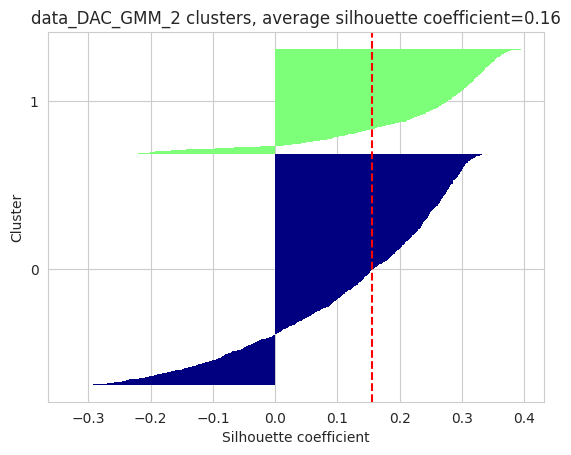

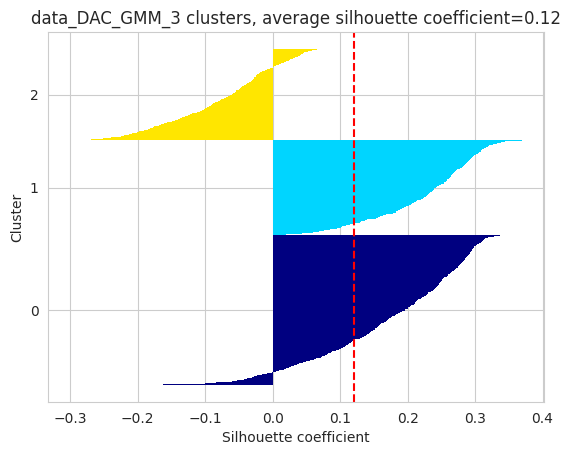

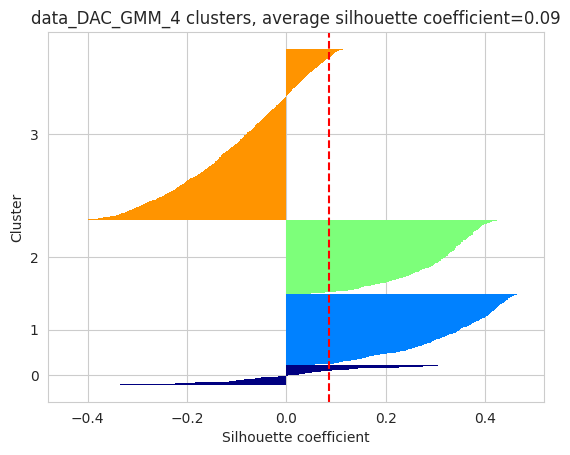

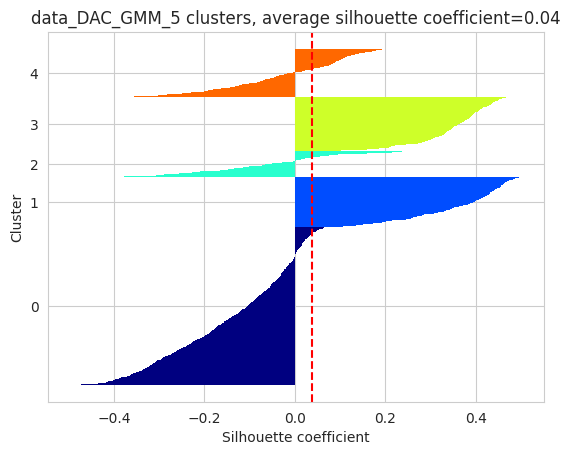

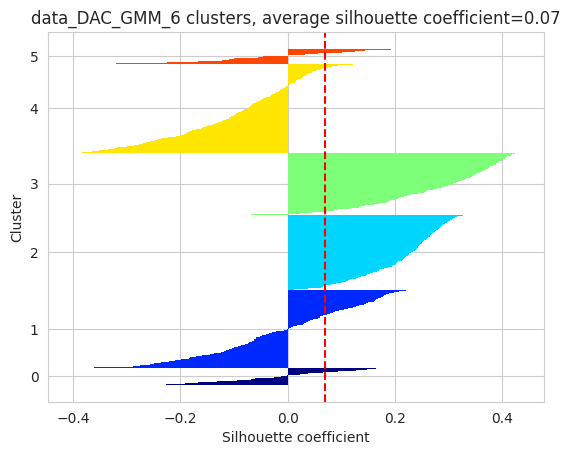

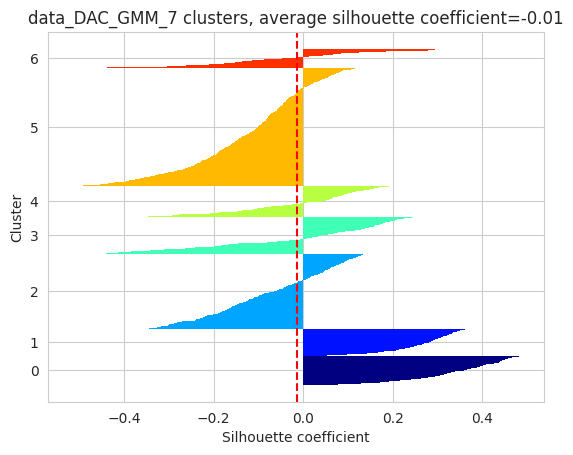

In [ ]:
for i in range(2,8):
    GMM = GaussianMixture(n_components=i)
    GMM.fit(X_std)
    labels = GMM.predict(X_std)
    silhouette_analysis(labels,X_std, model = "GMM")

#### accuracy

C:\Users\lzowe\anaconda3\envs\SMU_cluster_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

       False       0.74      0.92      0.82      1261
        True       0.23      0.07      0.11       437

    accuracy                           0.70      1698
   macro avg       0.48      0.49      0.46      1698
weighted avg       0.61      0.70      0.64      1698



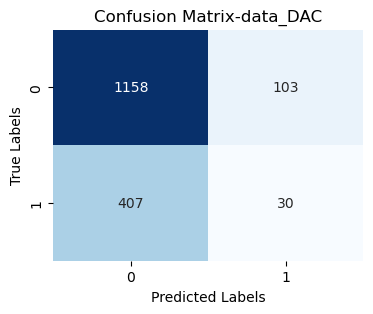

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
model = "GMM"
# we decide choose two clusters
GMM2 = GaussianMixture(n_components=2)
GMM2.fit(X_std)
labels = GMM2.predict(X_std)

# compare actual vs predicted results
actual_labels = y
pred_lables = labels


print("Classification Report:")
print(classification_report(actual_labels, pred_lables))

# Generate confusion matrix
plt.figure(figsize=(4, 3))
cm = confusion_matrix(actual_labels, pred_lables)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title(f"Confusion Matrix-{dataset}")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig(f"plot/confusionMatrix_{dataset}_{model}.png")
plt.show()

#### step 4

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve, validation_curve, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

model = "Hierarchical"
DR = "PCA"
step = "step4"
features = X_pca
target = y

# Convert 'True' and 'False' to 1 and 0
target = target.astype(int)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Set up MLP model
mlpclf = MLPClassifier(hidden_layer_sizes=(100,), activation='logistic', solver='sgd', max_iter=1000, random_state=42)
mlpclf.fit(X_train, y_train)


for flag in ["train", "test"]:
    
    actual_labels = y_train if flag == "train" else y_test
    pred_lables = mlpclf.predict(X_train) if flag == "train" else mlpclf.predict(X_test)


    print(f"Classification Report_{dataset}_{DR}_{flag}:")
    print(classification_report(actual_labels, pred_lables))

    # Generate confusion matrix
    plt.figure(figsize=(4, 3))
    cm = confusion_matrix(actual_labels, pred_lables)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"ConfusionMatrix_{dataset}_{DR}_{flag}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.savefig(f"plot_step4/CM{dataset}{DR}{flag}.png")
    plt.show()